# National Institute of Technology Karnataka

Import all the necessary libraries

In [1]:
%matplotlib inline
# Import torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Import non-deeplearning libraries
from tqdm.notebook import tqdm
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from glob import glob

# Import libraries for images manipulation and visualization
import matplotlib.pyplot as plt
import cv2

# Check if a GPU is available
CUDA = torch.cuda.is_available()
print("CUDA :: ", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

CUDA ::  True


# Model definition

The base paper for the VGG net can be found [here](https://arxiv.org/pdf/1409.1556.pdf)

In [2]:
class VGG16(nn.Module):
    def __init__(self, hidden = 64, no_of_classes=2, kernel_size=(3,3), padding=1, stride=(1,1)):
        super(VGG16, self).__init__()
        '''
        Initializes the layers for the neral network model. The VGG-16 with Batch Normalization is used
        
        Arguments:
        hidden  --  The number of channels for the first layer. The no of channels for the consequent layers are a multiple of this number
        no_of_classes --  The number of output classes
        kernel_size  --  Filter Size for the Conv layers
        padding  --  Padding for the Conv layers. For SAME conv, padding = (kernel_size - 1)/2
        stride  --  Stride for the Conv layers
        
        Return:
        None
        '''
        # Input Shape is 64x64
        # Block 1. It consists of the Conv layers till the first max pooling layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features = hidden)
        self.conv2 = nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn2 = nn.BatchNorm2d(num_features = hidden)
        self.max1  = nn.MaxPool2d(kernel_size = (2,2), stride = 2)

        # Block 2. It consists of the Conv layers till the second max pooling layer
        self.conv3 = nn.Conv2d(in_channels=hidden, out_channels=2*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn3 = nn.BatchNorm2d(num_features = 2*hidden)
        self.conv4 = nn.Conv2d(in_channels=2*hidden, out_channels=2*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn4 = nn.BatchNorm2d(num_features = 2*hidden)
        self.max2  = nn.MaxPool2d(kernel_size = (2,2), stride = 2)

        # Block 3. It consists of the Conv layers till the third max pooling layer
        self.conv5 = nn.Conv2d(in_channels=2*hidden, out_channels=4*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn5 = nn.BatchNorm2d(num_features = 4*hidden)
        self.conv6 = nn.Conv2d(in_channels=4*hidden, out_channels=4*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn6 = nn.BatchNorm2d(num_features = 4*hidden)
        self.conv7 = nn.Conv2d(in_channels=4*hidden, out_channels=4*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn7 = nn.BatchNorm2d(num_features = 4*hidden)
        self.max3  = nn.MaxPool2d(kernel_size = (2,2), stride = 2)

        # Block 4. It consists of the Conv layers till the fourth max pooling layer
        self.conv8  = nn.Conv2d(in_channels=4*hidden, out_channels=8*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn8 = nn.BatchNorm2d(num_features = 8*hidden)
        self.conv9  = nn.Conv2d(in_channels=8*hidden, out_channels=8*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn9 = nn.BatchNorm2d(num_features = 8*hidden)
        self.conv10 = nn.Conv2d(in_channels=8*hidden, out_channels=8*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn10 = nn.BatchNorm2d(num_features = 8*hidden)
        self.max4  = nn.MaxPool2d(kernel_size = (2,2), stride = 2)

        # Block 5. It consists of the Conv layers till the fifth max pooling layer
        self.conv11 = nn.Conv2d(in_channels=8*hidden, out_channels=8*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn11 = nn.BatchNorm2d(num_features = 8*hidden)
        self.conv12 = nn.Conv2d(in_channels=8*hidden, out_channels=8*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn12 = nn.BatchNorm2d(num_features = 8*hidden)
        self.conv13 = nn.Conv2d(in_channels=8*hidden, out_channels=8*hidden, kernel_size=kernel_size, padding=padding, stride=stride)
        self.bn13 = nn.BatchNorm2d(num_features = 8*hidden)
        self.max5  = nn.MaxPool2d(kernel_size = (2,2), stride = 2)

        # Fully connected layers and Classification
        # in_features = dim x dim x 512
        # dim = input_shape / 32. Dimensions after the 32x downsampling
        self.fc1 = nn.Linear(in_features=2*2*512, out_features = 4096)
        self.fc2 = nn.Linear(in_features=4096, out_features = 4096)
        self.final_layer = nn.Linear(in_features=4096, out_features=no_of_classes)

    def forward(self, x):
        '''
        Forward propogation of the model. The ReLU activations are used for the Conv layers
        
        Arguments:
        x  --  Input to the VGG network
        
        Returns
        y  --  Output of the VGG network
        '''
        # Block 1
        x_1 = nn.ReLU()(self.bn1(self.conv1(x)))
        x_1 = nn.ReLU()(self.bn2(self.conv2(x_1)))
        x_1 = self.max1(x_1)

        # Block 2
        x_2 = nn.ReLU()(self.bn3(self.conv3(x_1)))
        x_2 = nn.ReLU()(self.bn4(self.conv4(x_2)))
        x_2 = self.max2(x_2)

        # Block 3
        x_3 = nn.ReLU()(self.bn5(self.conv5(x_2)))
        x_3 = nn.ReLU()(self.bn6(self.conv6(x_3)))
        x_3 = nn.ReLU()(self.bn7(self.conv7(x_3)))
        x_3 = self.max3(x_3)

        # Block 4
        x_4 = nn.ReLU()(self.bn8(self.conv8(x_3)))
        x_4 = nn.ReLU()(self.bn9(self.conv9(x_4)))
        x_4 = nn.ReLU()(self.bn10(self.conv10(x_4)))
        x_4 = self.max4(x_4)

        # Block 5
        x_5 = nn.ReLU()(self.bn11(self.conv11(x_4)))
        x_5 = nn.ReLU()(self.bn12(self.conv12(x_5)))
        x_5 = nn.ReLU()(self.bn13(self.conv12(x_5)))
        x_5 = self.max5(x_5)

        # The 32x downsampled image is flattened and passed through Linear and Classification layers
        x_flat = nn.Flatten()(x_5)
        x_fc = self.fc1(x_flat)
        x_fc = self.fc2(x_fc)
        y = self.final_layer(x_fc)
        return y

In [3]:
# Hyper parameters for the model
num_classes = 2
batch_size = 64
learning_rate = 0.001

# Instantiate Model and mount it on the relavent device
vgg16model = VGG16()
vgg16model.to(device)

# Relavent PATHs for saving the model and loading the data
DATASET_FOLDER_PATH = '../input/breast-histopathology-images/'
CHECKPOINT_PATH = ''
LOAD_PICKLE = True
PICKLE_PATH = '../input/inputfiles/images_files_data.pkl'

# Instantiate Optimzer and Loss Function. The L2 regularization penalty factor is 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16model.parameters(), lr=learning_rate, weight_decay=5*(10**(-4)))

# Load the Dataframe

Load the dataframe from the pkl file containing the filenames and the label<br/>
If the pkl file does not exist, assign **LOAD_PICKLE** as False in the previous snippet

In [4]:
if LOAD_PICKLE == False:
    imagePatches = glob(DATASET_FOLDER_PATH + '**/*.png', recursive=True)
    print('Total number of files = ', len(imagePatches))
    y = []
    for img in imagePatches:
        if img.endswith('class0.png'):
            y.append(0)
        elif img.endswith('class1.png'):
            y.append(1)
    images_df = pd.DataFrame()
    images_df["images"] = imagePatches
    images_df["labels"] = y
    images_df.to_pickle(PICKLE_PATH)
else:
    images_df = pd.read_pickle(PICKLE_PATH)
    print('Read Complete. Total number of files = ', len(images_df))

Read Complete. Total number of files =  555048


# Examine the Data

In [5]:
# images_df = images_df[:40000]
images_df.head()

,images,labels
0,../input/breast-histopathology-images/14304/1/...,1
1,../input/breast-histopathology-images/14304/1/...,1
2,../input/breast-histopathology-images/14304/1/...,1
3,../input/breast-histopathology-images/14304/1/...,1
4,../input/breast-histopathology-images/14304/1/...,1


In [6]:
images_df.groupby("labels")["labels"].count()

labels
0    397476
1    157572
Name: labels, dtype: int64

In [7]:
#Splitting data into train and val
train, val = train_test_split(images_df, stratify=images_df.labels, test_size=0.2)
len(train), len(val)

(444038, 111010)

# Instantiate the Data loader

In [8]:
class IDC_Dataset(Dataset):
    def __init__(self, data_from,transform=None):
        super().__init__()
        '''
        Initialize the Dataloader
        
        Arguments:
        data_from  --  The dataframe with the filenames and the labels
        transform  --  The transformation to be applied to the input for normalization and/or data augmentation
        
        Returns:
        None
        '''
        self.data_from = data_from.values
        self.transform = transform

    def __len__(self):
        '''
        Calculate the number of file/data-points in the dataframe
        
        Arguments:
        None
        
        Returns:
        Number of files
        '''
        return len(self.data_from)
    
    def __getitem__(self, index):
        '''
        Based on the input index, reads a row(filename and the label) and outputs the loaded image and the label as a tensor
        
        Arguments:
        index  --  The index of the dataframe row to be loaded
        
        Returns:
        image  --  The image tensor of dimension [batch,channels,height,width]
        label  --  The label for the image loaded in a tensor format. Either 0 or 1
        '''
        img_path,label = self.data_from[index]
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [9]:
# Transformations for the traning and the validation DataLoader
training_transformation = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((64,64)), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

validation_transformation = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((64,64)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Instantiate the Data Loader classes
dataset_train = IDC_Dataset(train, transform=training_transformation)
dataset_valid = IDC_Dataset(val,transform=validation_transformation)

# Instantiate the iterators
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size//2, shuffle=False)

In [10]:
# Train the model
num_epochs = 50
resume_epoch = 50
# loss_train = []
if resume_epoch == 0 :
    print("Start Traning")
elif resume_epoch == num_epochs:
    print("Traning Completed")
else:
    print("Resume Training. Last Epoch ", resume_epoch)
    checkpoint = torch.load('../input/secondckpt/' + str(resume_epoch) + '.tar', map_location=torch.device(device))
    vgg16model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


loss_train = []
loss_valid = []
train_length = len(loader_train)
val_length   = len(loader_valid)
for epoch in range(resume_epoch, num_epochs):
    # intialize the metrics and losses to 0
    loss_epoch = 0
    val_loss = 0
    accuracy_train = 0
    accuracy_val = 0
    f1_score_train = 0
    f1_score_val = 0
    jaccard_train = 0
    jaccard_val = 0
    # Enable traning mode 
    vgg16model.train()
    for (images, labels) in loader_train:
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = vgg16model(images)
        loss = criterion(outputs, labels)
        loss_epoch += loss.item()
        
        # Conversion to numpy
        output_numpy = np.argmax(outputs.clone().detach().cpu().numpy(), axis=1).ravel()
        labels_numpy = labels.cpu().numpy().ravel()
        
        # Metrics
        accuracy_train += accuracy_score(labels_numpy, output_numpy)
        f1_score_train += f1_score(labels_numpy, output_numpy, average='weighted')
        jaccard_train += jaccard_score(labels_numpy, output_numpy, average='weighted')
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Print the outputs
    print("Epoch : ", epoch + 1, " Loss : ", loss_epoch/train_length, " Accuracy : ", accuracy_train/train_length," F1/Dice : ", f1_score_train/train_length, " Jaccard/IoU : ", jaccard_train/train_length)
    if((epoch+1) % 10 == 0):
        print('Saving model stats')
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': vgg16model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_epoch}, CHECKPOINT_PATH + str(epoch+1) + '.tar')
    loss_train.append(loss_epoch)

    # Validation
    # Enable evaluation mode
    vgg16model.eval()
    with torch.no_grad():
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            outputs = vgg16model(images)
            
            # Conversion to numpy
            output_numpy = np.argmax(outputs.clone().detach().cpu().numpy(), axis=1).ravel()
            labels_numpy = labels.cpu().numpy().ravel()
            
            # Metrics
            accuracy_val += accuracy_score(labels_numpy, output_numpy)
            f1_score_val += f1_score(labels_numpy, output_numpy, average='weighted')
            jaccard_val += jaccard_score(labels_numpy, output_numpy, average='weighted')

            val_loss += criterion(outputs, labels)
        save_file = open('save.txt', 'a')
        print("Validation Loss : ", val_loss.item()/val_length, " Accuracy : ", accuracy_val/val_length, " F1/Dice : ", f1_score_val/val_length, " Jaccard/IoU : ", jaccard_val/val_length, file=save_file)
        print(" ", file=save_file)
        save_file.close
        print()

Traning Completed


# Testing Loop

In [11]:
accuracy_test  = 0
f1_score_test   = 0
jaccard_test  = 0
precision_test = 0
recall_test = 0
pred_list  = []
label_list = []

# Load the model state dictionary
checkpoint = torch.load('../input/finalckpt/' + str(50) + '.tar', map_location=torch.device(device))
vgg16model.load_state_dict(checkpoint['model_state_dict'])

# Enable testing mode
vgg16model.eval()
test_length = len(loader_valid)

with torch.no_grad():
    for images, labels in tqdm(loader_valid):
        # Seat the images and labels to the designated device
        images = images.to(device)
        labels = labels.to(device)
        # Calculate model output
        outputs = vgg16model(images)
        
        # Convert output to numpy variables
        output_numpy = np.argmax(outputs.clone().detach().cpu().numpy(), axis=1).ravel()
        labels_numpy = labels.cpu().numpy().ravel()
        
        # Metric Calculation
        accuracy_test += accuracy_score(labels_numpy, output_numpy)
        f1_score_test  += f1_score(labels_numpy, output_numpy, average='weighted')
        jaccard_test += jaccard_score(labels_numpy, output_numpy, average='weighted')
        precision_test += precision_score(labels_numpy, output_numpy, average='weighted')
        recall_test += recall_score(labels_numpy, output_numpy, average='weighted')
        
        pred_list.append(output_numpy)
        label_list.append(labels_numpy)
    print(" Accuracy : ", accuracy_test/test_length, " Jaccard/IoU : ", jaccard_test/test_length)
    print("F1/Dice : ", f1_score_test/test_length, " Precision : ", precision_test/test_length, " Recall : ", recall_test/test_length)


 Accuracy :  0.895064841498559  Jaccard/IoU :  0.8213702044697411
F1/Dice :  0.8973128812161003  Precision :  0.9077056461101652  Recall :  0.895064841498559


# Calculate the Confusion Matrix

In [12]:
label_list = np.concatenate(label_list)
pred_list = np.concatenate(pred_list)
cm = confusion_matrix(label_list.ravel(), pred_list.ravel())
cm

array([[71751,  7744],
       [ 3908, 27607]])

# Plot the Confusion Matrix

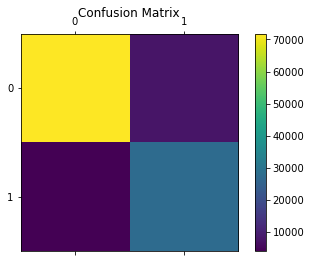

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, interpolation='nearest')
fig.colorbar(cax)
ax.set_xticklabels(['']+['0', '1'])
ax.set_yticklabels(['']+['0', '1'])
plt.title('Confusion Matrix')
plt.show()